In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from scipy.optimize import minimize, Bounds

from thesis.io import mesa, gyre, fgong
from thesis.physics import first_adiabatic_exponent, sound_speed, acoustic_depth, structure_kernels
from thesis.calculus import differentiate

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [5]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [6]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [8]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


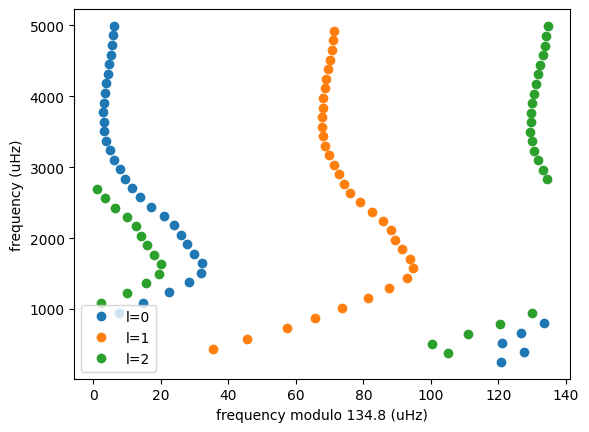

In [16]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

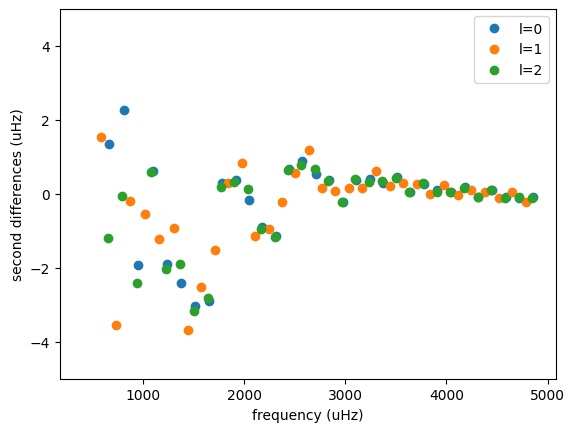

In [17]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

Let us model just the $l=0$ modes, from $n=10$ to $n=30$

In [221]:
n = np.arange(10, 30)
nu = data.freq.real.sel(l=0, n_pg=n)
delta_nu = nu.diff(dim="n_pg").mean().values
nu = nu.values()

Text(0, 0.5, 'frequency (uHz)')

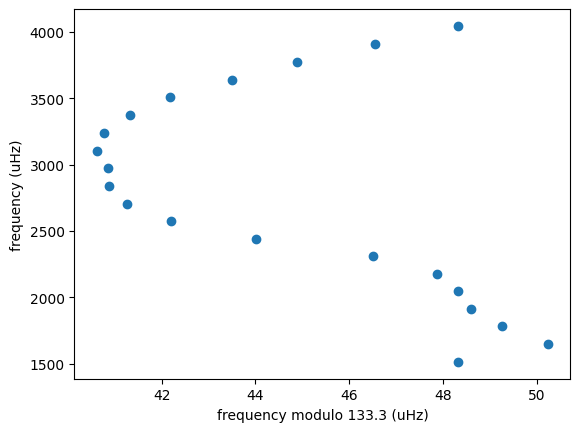

In [48]:
fig = plt.figure()

plt.plot(nu%delta_nu, nu, 'o')

plt.xlabel(f'frequency modulo {delta_nu:.1f} (uHz)')
plt.ylabel('frequency (uHz)')

In [422]:
def model(params, n, n0=20):
    nu_sm = params[0] * np.polyval(params[1:], (n - n0))
    return nu_sm

def chi_squared(params, n, nu, sigma=0.01, n0=20, reg=7.0):
    return (
        (((nu - model(params, n, n0=n0)) / sigma)**2).sum() 
        + (reg * params[0])**2 * ((24*params[1]*(n-n0) + 6*params[2])**2).sum()
    )

In [423]:
n0 = 20
init_params = np.array([delta_nu, -1e-5, 1e-5, 8e-4, 1.0, n0+1.3])
nu_init = model(init_params, n)

Text(0, 0.5, 'frequency (uHz)')

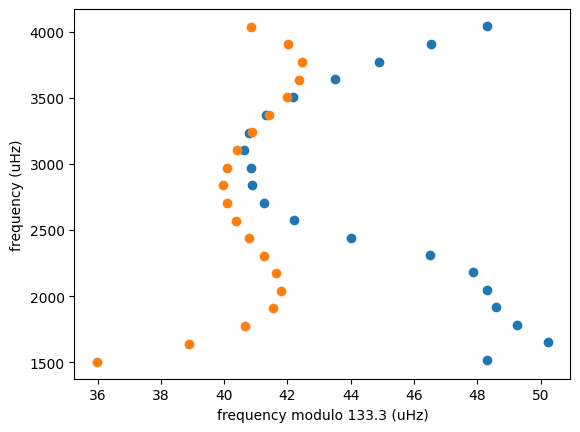

In [424]:
fig = plt.figure()

plt.plot(nu%delta_nu, nu, 'o')
plt.plot(nu_init%delta_nu, nu_init, 'o')

plt.xlabel(f'frequency modulo {delta_nu:.1f} (uHz)')
plt.ylabel('frequency (uHz)')

In [425]:
res = minimize(chi_squared, init_params, args=(n, nu), method="Powell")
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 36793.42981863049
       x: [ 1.334e+02 -6.635e-06  5.422e-05  1.270e-03  9.942e-01
            2.129e+01]
     nit: 7
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [-1.967e-03  1.217e-06 ... -1.596e-03 -6.393e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-4.155e-02 -2.050e-06 ...  6.075e-04  4.543e-03]]
    nfev: 370

Text(0, 0.5, 'frequency (uHz)')

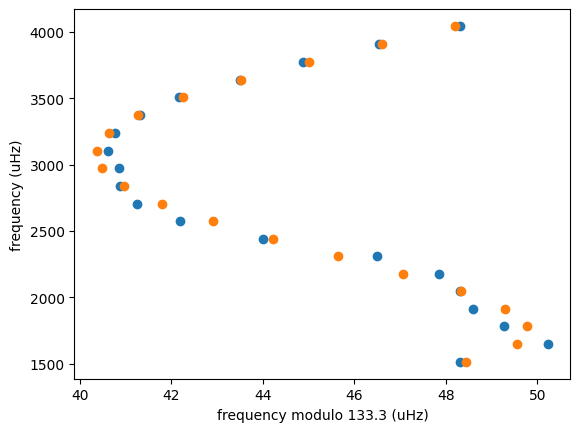

In [426]:
nu_pred = model(res.x, n)
fig = plt.figure()

plt.plot(nu%delta_nu, nu, 'o')
plt.plot(nu_pred%delta_nu, nu_pred, 'o')

plt.xlabel(f'frequency modulo {delta_nu:.1f} (uHz)')
plt.ylabel('frequency (uHz)')

In [427]:
def oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def he_glitch(nu, a, b, tau, phi):
    return a * nu * np.exp(- b * nu**2) * oscillation(nu, tau, phi)

In [428]:
def model(params, n, nu, n0=20):
    nu_sm = params[0] * np.polyval(params[1:6], (n - n0))
    dnu_he = he_glitch(nu_sm, *params[6:])
#     dnu_cz = cz_glitch(nu_sm, *params[10:])
    return nu_sm + dnu_he

def chi_squared(params, n, nu, sigma=0.01, n0=20, reg=7.0):
    return (
        (((nu - model(params, n, nu, n0=n0)) / sigma)**2).sum() 
        + (reg * params[0])**2 * ((24*params[1]*(n-n0) + 6*params[2])**2).sum()
    )

In [429]:
tau_he = 0.1/delta_nu
gamma_he = 2e-5
delta_he = 0.1 * tau_he

a_he = gamma_he * delta_nu
b_he = 8 * np.pi**2 * delta_he**2

init_params = np.concatenate([
    res.x,
    [a_he, b_he, tau_he, 0.0]
])

nu_init = model(init_params, n, nu)

Text(0, 0.5, 'frequency (uHz)')

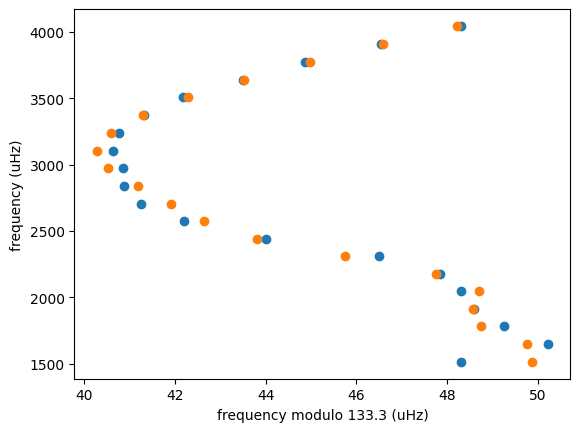

In [430]:
fig = plt.figure()

plt.plot(nu%delta_nu, nu, 'o')
plt.plot(nu_init%delta_nu, nu_init, 'o')

plt.xlabel(f'frequency modulo {delta_nu:.1f} (uHz)')
plt.ylabel('frequency (uHz)')

In [ ]:
lb = [delta_nu*0.9, -1e-4, 0.0, 0.0, 0.9, n0*0.8, 0.6*a_he, 0.6*b_he, tau_he*0.8, -np.pi]
ub = [delta_nu*1.1, 0.0, 1e-3, 1e-2, 1.0, n0*1.2, 1.4*a_he, 1.4*b_he, tau_he*1.2, np.pi]
bounds = Bounds(lb, ub)

In [431]:
res = minimize(
    chi_squared, init_params, args=(n, nu), method="L-BFGS-B",
    bounds=bounds,
)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 10130.244040916377
        x: [ 1.334e+02 -8.955e-06  5.617e-05  1.433e-03  9.942e-01
             2.129e+01  2.657e-03  4.146e-07  7.154e-04 -9.697e-04]
      nit: 53
      jac: [ 6.970e+04  6.191e+08 -3.520e+08  1.043e+07  1.831e+06
             3.516e+05  2.421e+06  1.096e+09 -1.183e+07  4.119e+02]
     nfev: 1122
     njev: 102
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

Text(0, 0.5, 'frequency (uHz)')

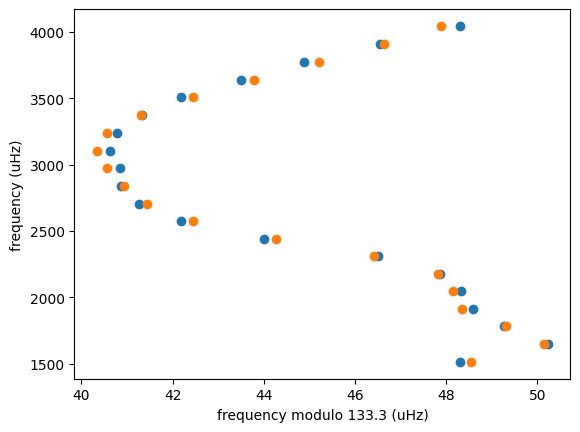

In [432]:
nu_pred = model(res.x, n, nu)
fig = plt.figure()

plt.plot(nu%delta_nu, nu, 'o')
plt.plot(nu_pred%delta_nu, nu_pred, 'o')

plt.xlabel(f'frequency modulo {delta_nu:.1f} (uHz)')
plt.ylabel('frequency (uHz)')

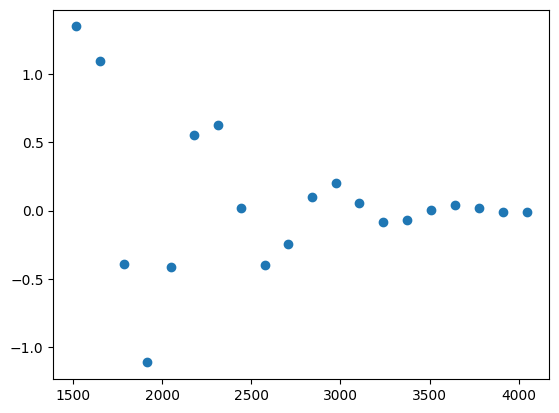

In [436]:
dnu_he = he_glitch(nu, *res.x[6:])
plt.plot(nu, dnu_he, "o")

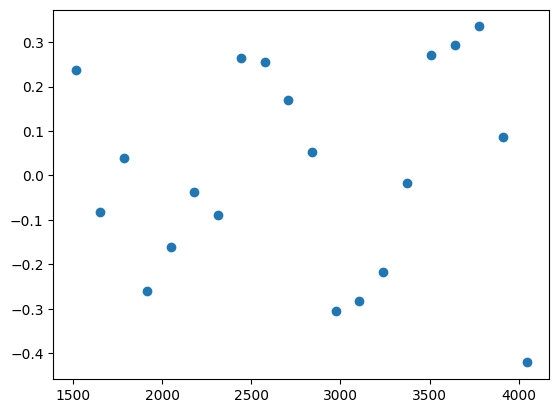

In [434]:
plt.plot(nu, nu_pred - nu, "o")

In [442]:
def cz_glitch(nu, a, tau, phi):
    return a / nu**2 * oscillation(nu, tau, phi)

def model(params, n, nu, n0=20):
    nu_sm = params[0] * np.polyval(params[1:6], (n - n0))
    dnu_he = he_glitch(nu_sm, *params[6:10])
    dnu_cz = cz_glitch(nu_sm, *params[10:])
    return nu_sm + dnu_he

def chi_squared(params, n, nu, sigma=0.01, n0=20, reg=7.0):
    return (
        (((nu - model(params, n, nu, n0=n0)) / sigma)**2).sum() 
        + (reg * params[0])**2 * ((24*params[1]*(n-n0) + 6*params[2])**2).sum()
    )

In [443]:
tau_cz = 0.3/delta_nu
a_cz = 1e3*delta_nu

init_params = np.concatenate([
    res.x,
    [a_cz, tau_cz, 0.0]
])

nu_init = model(init_params, n, nu)

Text(0, 0.5, 'frequency (uHz)')

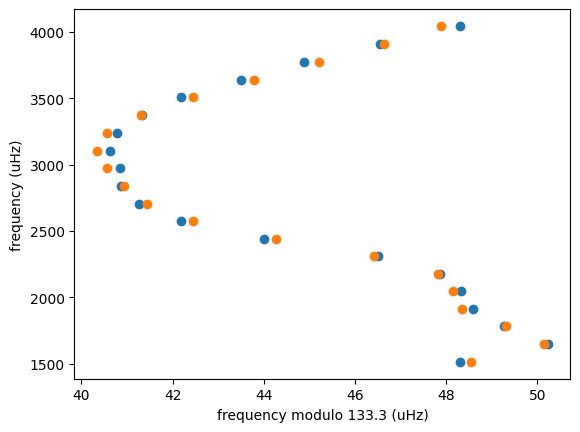

In [444]:
fig = plt.figure()

plt.plot(nu%delta_nu, nu, 'o')
plt.plot(nu_init%delta_nu, nu_init, 'o')

plt.xlabel(f'frequency modulo {delta_nu:.1f} (uHz)')
plt.ylabel('frequency (uHz)')

In [445]:
lb = np.concatenate([
    lb, [0.6*a_cz, 0.8*tau_cz, -np.pi]
])

ub = np.concatenate([
    ub, [1.4*a_cz, 1.2*tau_cz, np.pi]
])
bounds = Bounds(lb, ub)

In [446]:
res = minimize(
    chi_squared, init_params, args=(n, nu), method="L-BFGS-B",
    bounds=bounds,
)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 10115.131757936771
        x: [ 1.334e+02 -8.956e-06 ...  2.251e-03  0.000e+00]
      nit: 3
      jac: [ 2.250e+04  9.450e+06 ...  0.000e+00  0.000e+00]
     nfev: 574
     njev: 41
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>

Text(0, 0.5, 'frequency (uHz)')

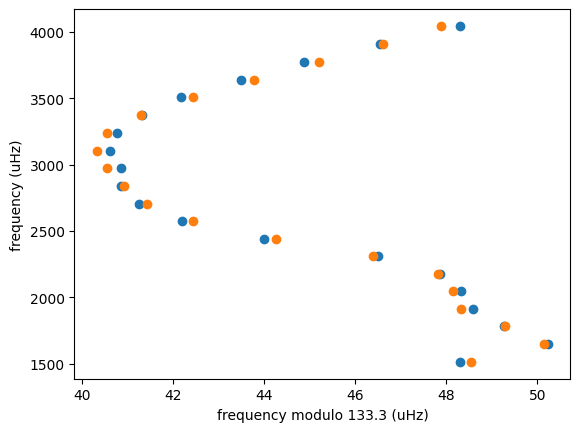

In [447]:
nu_pred = model(res.x, n, nu)
fig = plt.figure()

plt.plot(nu%delta_nu, nu, 'o')
plt.plot(nu_pred%delta_nu, nu_pred, 'o')

plt.xlabel(f'frequency modulo {delta_nu:.1f} (uHz)')
plt.ylabel('frequency (uHz)')

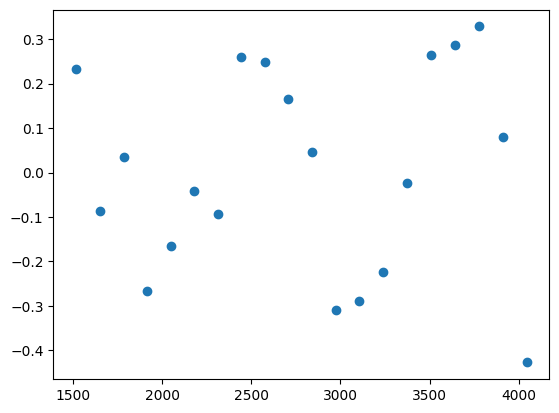

In [452]:
plt.plot(nu, nu_pred - nu, "o")

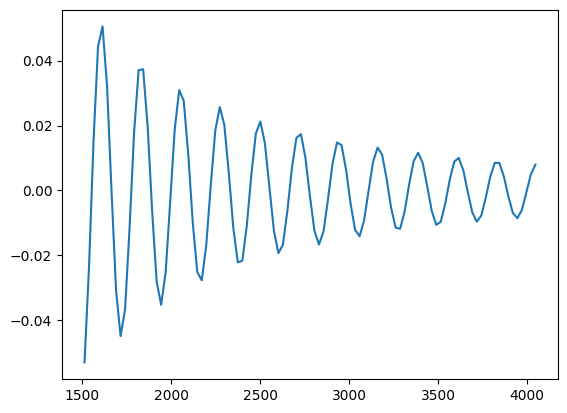

In [451]:
nu_cont = np.linspace(nu.min(), nu.max(), 101)
dnu_cz = cz_glitch(nu_cont, *res.x[10:])
plt.plot(nu_cont, dnu_cz)